##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [8]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils import shuffle
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet

train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

train_data

,Unnamed: 0,id,text,sentiment
0,2,805582613687713000,doctors hit campaign trail as race to medical...,neutral
1,3,637480203497832000,is anybody going to the radio station tomorro...,positive
2,4,641096279930507000,i just found out naruto didn't become the 5th...,neutral
3,5,625730917647126000,"""prince george reservist who died saturday ju...",neutral
4,6,633292370906230000,season in the sun versi nirvana rancak gak..s...,positive
...,...,...,...,...
21797,27896,805677750363095000,@hrtablaze the beginning of a dictatorship is ...,negative
21798,27897,637854813930196000,son idc anymore. i'm going by shawn tomorrow,neutral
21799,27898,802374277047656000,but remember the clinton foundation?? https://...,neutral
21800,27899,640441306494296000,"press: ""r u worried murray dominated his 3rd r...",neutral


In [9]:
# list of data to download from nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chautuananh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chautuananh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chautuananh/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chautuananh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Then we separate the tweet text and the label (sentiment). 

In [10]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [11]:
#Let's see one example tweet
print(X_train_raw[1])

 is anybody going to the radio station tomorrow to see shawn? me and my friend may go but we would like to make new friends/meet there (:	


### 1. Bag of Words (BoW)
In this approach, we use the **CountVectorizer** library to separate all the words in the Train corpus (dataset). These words are then used as the 'vectors' or 'features' to represent each instance (Tweet) in `Train` and `Test` datasets. 

In [12]:
BoW_vectorizer = CountVectorizer()

#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW = BoW_vectorizer.fit_transform(X_train_raw)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_BoW = BoW_vectorizer.transform(X_test_raw)

print("Train feature space size (using BoW):",X_train_BoW.shape)
print("Test feature space size (using BoW):",X_test_BoW.shape)

Train feature space size (using BoW): (21802, 44045)
Test feature space size (using BoW): (6099, 44045)


Now each row is a list of tuples with the vector_id (word_id in the vocabulary) and the number of times it repeated in that given instance (tweet).

In [13]:
#Let's see one example tweet using the BoW feature space
print(X_train_BoW[1])

  (0, 38395)	3
  (0, 19715)	1
  (0, 3989)	1
  (0, 16331)	1
  (0, 37689)	1
  (0, 31309)	1
  (0, 36044)	1
  (0, 38468)	1
  (0, 34040)	1
  (0, 34418)	1
  (0, 24586)	1
  (0, 3761)	1
  (0, 26105)	1
  (0, 15223)	1
  (0, 24454)	1
  (0, 16261)	1
  (0, 7246)	1
  (0, 41365)	1
  (0, 42083)	1
  (0, 22991)	1
  (0, 23985)	1
  (0, 26660)	1
  (0, 15226)	1
  (0, 24659)	1
  (0, 37883)	1


We can save the created vocabulary for the given dataset in a separate file.

In [14]:
output_dict = BoW_vectorizer.vocabulary_
output_pd = pd.DataFrame(list(output_dict.items()),columns = ['word','count'])

output_pd.T.to_csv('BoW-vocab.csv',index=False)

### 2. TFIDF
In this approach, we use the **TfidfVectorizer** library to separate all the words in this corpus (dataset). Same as the BoW approach, these words are then used as the 'vectors' or 'features' to represent each instance (Tweet).

However, in this method for each instance the value associated with each 'vector' (word) is not the number of times the word repeated in that tweet, but the TFIDF value of then 'voctor' (word).

In [15]:
tfidf_vectorizer = TfidfVectorizer()

# Build the feature set (vocabulary) and vectorise the Train dataset using TFIDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)

# Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

print("Train feature space size (using TFIDF):",X_train_tfidf.shape)
print("Test feature space size (using TFIDF):",X_test_tfidf.shape)


Train feature space size (using TFIDF): (21802, 44045)
Test feature space size (using TFIDF): (6099, 44045)


In [16]:
#Let's see one example tweet using the TFIDF feature space
print(X_train_tfidf[1])

  (0, 37883)	0.18565385954834512
  (0, 24659)	0.2500345232367134
  (0, 15226)	0.25639046572035723
  (0, 26660)	0.17561152736960378
  (0, 23985)	0.1925927500306722
  (0, 22991)	0.16044767939535962
  (0, 42083)	0.18984640176982912
  (0, 41365)	0.1543207744837252
  (0, 7246)	0.14059126992943502
  (0, 16261)	0.1784628628725588
  (0, 24454)	0.12804387104621462
  (0, 15223)	0.26344567340807307
  (0, 26105)	0.14662061838154353
  (0, 3761)	0.09883064069307852
  (0, 24586)	0.1579972519146742
  (0, 34418)	0.22806178452645745
  (0, 34040)	0.1638445966736955
  (0, 38468)	0.13527781692615354
  (0, 36044)	0.34058106427217183
  (0, 31309)	0.2838666463265357
  (0, 37689)	0.06611242944726782
  (0, 16331)	0.16788221772423795
  (0, 3989)	0.29703234834833714
  (0, 19715)	0.1065038202170494
  (0, 38395)	0.2534685554135372


Our baseline evaluation, which is a Zero-R baseline

In [17]:
# Use ZeroR as our baseline
def baseline(train_data, test_data):
    frequencies = Counter(train_data).most_common(1)[0][0]
    print(Counter(train_data).most_common)
    return [frequencies] * len(test_data)

sentiments = pd.DataFrame({
  "id": [x[0] for x in test_data[['id']].values],
  "sentiment": baseline(Y_train, X_test_raw)
})
sentiments.to_csv("zeror.csv", index=False)

<bound method Counter.most_common of Counter({'neutral': 12659, 'positive': 5428, 'negative': 3715})>


In [24]:
# Preprocess function

negation_dict = {
    "don't": "do not",
    "can't": "can not",
    "couldn't": "could not",
    "didn't": "did not",
    "haven't": "have not",
    "hadn't": "had not",
    "isn't": "is not",
    "aren't": "are not",
    "ain't": "am not",
    "won't": "will not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "mustn't": "must not",
    "wasn't": "was not",
    "weren't": "were not",
}

lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
stop_words = stopwords.words("english")
stop_words.append("may")

tag_dict = defaultdict(lambda: wordnet.NOUN)
tag_dict['J'] = wordnet.ADJ
tag_dict['V'] = wordnet.VERB
tag_dict['R'] = wordnet.ADV

def preprocess(data):
    result = []
    for instance in data:
        instance = instance.lower()

        # Remove usernames and hyperlinks
        instance = re.sub(r"@\S*|https?://\S*|\d", "", instance)
        
        # Remove whitespaces
        instance = re.sub(r"\s\s+", " ", instance)

        instance = instance.split()

        for j in range(len(instance)):
            # Negation handling
            if instance[j] in negation_dict:
                instance[j] = negation_dict[instance[j]]

            # Remove special character
            instance[j] = re.sub(r"[^\sa-zA-Z0-9]+", " ", instance[j])

            # Normalize characters - convert characters that appear 3 or more times consecutively to a single character
            instance[j] = re.sub(r'([a-z])\1{2,}', r'\1', instance[j])

        # Remove stop words
        instance = list(filter(lambda x: x not in stop_words or x == "not", instance))
        # Lemmatize the words
        tags = pos_tag(instance)
        instance = list(map(lambda item: lemmatizer.lemmatize(item[0], tag_dict[item[1][0]]), tags))

        instance = " ".join(instance)

        # if instance:
        result.append(instance)
    return result

In [19]:
# Remove neutral instances to avoid biased in training
neutrals = train_data[train_data['sentiment'] == "neutral"]
neutrals = neutrals.sample(frac=0.5, random_state=1)
positives = train_data[train_data['sentiment'] == "positive"]
negatives = train_data[train_data['sentiment'] == "negative"]

# Patch together
unbiased_dataset = neutrals.append(positives, ignore_index=True)
unbiased_dataset = unbiased_dataset.append(negatives, ignore_index=True)
unbiased_dataset = unbiased_dataset.sample(frac=1, random_state=1)

In [30]:
# Perform 10 fold cross-validation on MNB

mnb = MultinomialNB()

kf = KFold(n_splits=10)
kf.get_n_splits(unbiased_dataset)

accuracies_MNB = []
positive_MNB = defaultdict(list)
negative_MNB = defaultdict(list)
neutral_MNB = defaultdict(list)

for train_index, test_index in kf.split(unbiased_dataset):
    train = unbiased_dataset.iloc[train_index]
    test = unbiased_dataset.iloc[test_index]
    X_train = [x[0] for x in train[['text']].values]
    Y_train = [x[0] for x in train[['sentiment']].values]
    X_test = [x[0] for x in test[['text']].values]
    Y_test = [x[0] for x in test[['sentiment']].values]
    
    # Preprocess the data
    tfidf_vectorizer = TfidfVectorizer()
    processed_data = preprocess(X_train)
    processed_data_tf_idf = tfidf_vectorizer.fit_transform(processed_data)
    processed_test_data_tf_idf = tfidf_vectorizer.transform(X_test)

    mnb.fit(processed_data_tf_idf, Y_train)
    prediction = mnb.predict(processed_test_data_tf_idf)
    result = precision_recall_fscore_support(Y_test, prediction, average=None, labels=['positive', 'neutral', 'negative'])
    positive_MNB["precision"].append(result[0][0])
    neutral_MNB["precision"].append(result[0][1])
    negative_MNB["precision"].append(result[0][2])
    positive_MNB["recall"].append(result[1][0])
    neutral_MNB["recall"].append(result[1][1])
    negative_MNB["recall"].append(result[1][2])
    positive_MNB["f1-score"].append(result[2][0])
    neutral_MNB["f1-score"].append(result[2][1])
    negative_MNB["f1-score"].append(result[2][2])
    
    accuracy = accuracy_score(Y_test, prediction)
    accuracies_MNB.append(accuracy)    
    

for key in positive_MNB:
    positive_MNB[key] = np.mean(positive_MNB[key])
    negative_MNB[key] = np.mean(negative_MNB[key])
    neutral_MNB[key] = np.mean(neutral_MNB[key])

df_MNB = pd.DataFrame([positive_MNB, negative_MNB, neutral_MNB], index=["positive", "negative", "neutral"])
df_MNB.round(3)

,precision,recall,f1-score
positive,0.649,0.590,0.618
negative,0.720,0.200,0.312
neutral,0.497,0.745,0.596


In [40]:
# 3-fold MNB

mnb_3 = MultinomialNB()

# Perform 10 fold cross-validation
kf = KFold(n_splits=3)
kf.get_n_splits(unbiased_dataset)

accuracies_3 = []
positive_MNB_3 = defaultdict(list)
negative_MNB_3 = defaultdict(list)
neutral_MNB_3 = defaultdict(list)

for train_index, test_index in kf.split(unbiased_dataset):
    train = unbiased_dataset.iloc[train_index]
    test = unbiased_dataset.iloc[test_index]
    X_train = [x[0] for x in train[['text']].values]
    Y_train = [x[0] for x in train[['sentiment']].values]
    X_test = [x[0] for x in test[['text']].values]
    Y_test = [x[0] for x in test[['sentiment']].values]

    # Preprocess the data
    tfidf_vectorizer = TfidfVectorizer()
    processed_data = preprocess(X_train)
    processed_data_tf_idf = tfidf_vectorizer.fit_transform(processed_data)
    processed_test_data_tf_idf = tfidf_vectorizer.transform(X_test)

    mnb_3.fit(processed_data_tf_idf, Y_train)
    prediction = mnb_3.predict(processed_test_data_tf_idf)
    result = precision_recall_fscore_support(Y_test, prediction, average=None, labels=['positive', 'neutral', 'negative'])
    positive_MNB_3["precision"].append(result[0][0])
    neutral_MNB_3["precision"].append(result[0][1])
    negative_MNB_3["precision"].append(result[0][2])
    positive_MNB_3["recall"].append(result[1][0])
    neutral_MNB_3["recall"].append(result[1][1])
    negative_MNB_3["recall"].append(result[1][2])
    positive_MNB_3["f1-score"].append(result[2][0])
    neutral_MNB_3["f1-score"].append(result[2][1])
    negative_MNB_3["f1-score"].append(result[2][2])
    
    accuracy = accuracy_score(Y_test, prediction)
    accuracies_3.append(accuracy)    

for key in positive_MNB_3:
    positive_MNB_3[key] = np.mean(positive_MNB_3[key])
    negative_MNB_3[key] = np.mean(negative_MNB_3[key])
    neutral_MNB_3[key] = np.mean(neutral_MNB_3[key])

df_MNB_3 = pd.DataFrame([positive_MNB_3, negative_MNB_3, neutral_MNB_3], index=["Positive", "Negative", "Neutral"])
df_MNB_3.round(3)

,precision,recall,f1-score
Positive,0.647,0.579,0.610
Negative,0.735,0.179,0.286
Neutral,0.494,0.755,0.597


In [33]:
# ================== MNB ON RAW DATA ==================

mnb_raw = MultinomialNB()

# Perform 10 fold cross-validation
kf = KFold(n_splits=10)
kf.get_n_splits(train_data)

accuracies_MNB_raw = []
positive_MNB_raw = defaultdict(list)
negative_MNB_raw = defaultdict(list)
neutral_MNB_raw = defaultdict(list)

for train_index, test_index in kf.split(train_data):
    train = train_data.iloc[train_index]
    test = train_data.iloc[test_index]
    X_train = [x[0] for x in train[['text']].values]
    Y_train = [x[0] for x in train[['sentiment']].values]
    X_test = [x[0] for x in test[['text']].values]
    Y_test = [x[0] for x in test[['sentiment']].values]

    # Preprocess the data
    tfidf_vectorizer = TfidfVectorizer()
    train_data_tf_idf = tfidf_vectorizer.fit_transform(X_train)
    test_data_tf_idf = tfidf_vectorizer.transform(X_test)

    mnb_raw.fit(train_data_tf_idf, Y_train)
    prediction = mnb_raw.predict(test_data_tf_idf)
    result = precision_recall_fscore_support(Y_test, prediction, average=None, labels=['positive', 'neutral', 'negative'])
    positive_MNB_raw["precision"].append(result[0][0])
    neutral_MNB_raw["precision"].append(result[0][1])
    negative_MNB_raw["precision"].append(result[0][2])
    positive_MNB_raw["recall"].append(result[1][0])
    neutral_MNB_raw["recall"].append(result[1][1])
    negative_MNB_raw["recall"].append(result[1][2])
    positive_MNB_raw["f1-score"].append(result[2][0])
    neutral_MNB_raw["f1-score"].append(result[2][1])
    negative_MNB_raw["f1-score"].append(result[2][2])
    
    accuracy = accuracy_score(Y_test, prediction)
    accuracies_MNB_raw.append(accuracy)    

for key in positive_MNB_raw:
    positive_MNB_raw[key] = np.mean(positive_MNB_raw[key])
    negative_MNB_raw[key] = np.mean(negative_MNB_raw[key])
    neutral_MNB_raw[key] = np.mean(neutral_MNB_raw[key])

df_MNB_raw = pd.DataFrame([positive_MNB_raw, negative_MNB_raw, neutral_MNB_raw], index=["positive", "negative", "neutral"])
df_MNB_raw.round(3)

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classificat

,precision,recall,f1-score
positive,0.828,0.049,0.092
negative,0.333,0.001,0.002
neutral,0.587,0.995,0.736


In [ ]:
# Having fitted 10 fold cross-validation, now we try the actual test
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]
X_test_raw = [x[0] for x in test_data[['text']].values]

train = preprocess(X_train_raw)
train = tfidf_vectorizer.fit_transform(train)
test = tfidf_vectorizer.transform(X_test_raw)

mnb.fit(train, Y_train)
prediction = mnb.predict(test)
score1 = accuracy_score(Y_test, prediction)
print("accuracy:   %0.3f" % score1)

print(classification_report(Y_test, prediction, target_names=['positive', 'negative', 'neutral']))

print("confusion matrix:")
print(confusion_matrix(Y_test, prediction))
# sentiments = pd.DataFrame({
#   "id": [x[0] for x in test_data[['id']].values],
#   "sentiment": prediction
# })
# sentiments.to_csv("MNB_sentiments.csv", index=False)

In [108]:
# Print the n most informative words associated with each class

def print_top_n(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))

def print_bot_n(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[:n]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))

positive: re, white, right, tomorrow, one, kill, think, fuck, make, bad, people, say, do, go, like, get, it, trump, may, not
neutral: one, know, trump, st, want, time, new, sunday, say, day, like, see, friday, it, get, tomorrow, go, th, may, not
negative: sunday, great, watch, like, best, time, good, friday, get, night, not, it, may, th, love, happy, go, see, day, tomorrow
positive: aa, moles, molly, molonlabe, molson, moly, moma, momentarily, moments, momma, mommy, moldy, mommynme, momthats, monaco, monastery, moncada, mondays, monet, monetary
neutral: zwei, dough, douchebag, douche, doubts, mydumdass, myer, myfamilyweir, mymasterpiece, dote, mymotog, dose, dos, dork, dor, dopest, mypresident, doors, mypresidentisblack, myra
negative: printable, recoup, guevara, sparking, guilt, sparen, guin, ocarina, ocampos, spare, guitarist, guiterriez, guji, gul, obvs, gullible, guesthouse, sparkle, guesstures, guessing


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Tuning C for SVM for C from 0.01 to 100

kf = KFold(n_splits=10)
kf.get_n_splits(unbiased_dataset)

accuracies_C_1 = []

for c in [0.01, 0.1, 1, 10, 1000]:
    train, test = train_test_split(unbiased_dataset, test_size=0.1, shuffle=False)
    X_train = [x[0] for x in train[['text']].values]
    Y_train = [x[0] for x in train[['sentiment']].values]
    X_test = [x[0] for x in test[['text']].values]
    Y_test = [x[0] for x in test[['sentiment']].values]
    
    # Preprocess the data
    tfidf_vectorizer = TfidfVectorizer()
    processed_data = preprocess(X_train)
    processed_data_tf_idf = tfidf_vectorizer.fit_transform(processed_data)
    processed_test_data_tf_idf = tfidf_vectorizer.transform(X_test)
    
    svm_model = svm.SVC(C=c,kernel='linear', degree=3, gamma='auto')
    svm_model.fit(processed_data_tf_idf, Y_train)
    prediction = svm_model.predict(processed_test_data_tf_idf)
    accuracy = accuracy_score(Y_test, prediction)
    accuracies_C_1.append(accuracy)  

([<matplotlib.axis.XTick at 0x127ec39a0>,
 [Text(1, 0, '0.01'),
  Text(2, 0, '0.1'),
  Text(3, 0, '1'),
  Text(4, 0, '10'),
  Text(5, 0, '1000')])

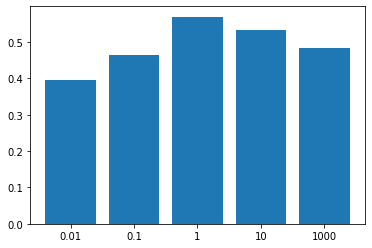

In [36]:
plt.bar(range(1, 6), accuracies_C_1)
plt.xticks(range(1, 6))
plt.xticks(range(1, 6), list(map(str, [0.01, 0.1, 1, 10, 1000])))

[0.5697674418604651, 0.5645994832041343, 0.5691214470284238, 0.5594315245478036, 0.5587855297157622, 0.5452196382428941, 0.5439276485788114, 0.5432816537467701, 0.5368217054263565, 0.5335917312661499]


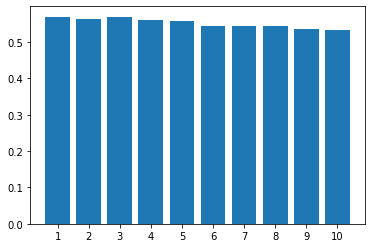

In [37]:
# Tuning C for SVM for C from 1 to 10

kf = KFold(n_splits=10)
kf.get_n_splits(unbiased_dataset)

accuracies_C_2 = []

for c in range(1, 11):
    train, test = train_test_split(unbiased_dataset, test_size=0.1, shuffle=False)
    X_train = [x[0] for x in train[['text']].values]
    Y_train = [x[0] for x in train[['sentiment']].values]
    X_test = [x[0] for x in test[['text']].values]
    Y_test = [x[0] for x in test[['sentiment']].values]
    
    # Preprocess the data
    tfidf_vectorizer = TfidfVectorizer()
    processed_data = preprocess(X_train)
    processed_data_tf_idf = tfidf_vectorizer.fit_transform(processed_data)
    processed_test_data_tf_idf = tfidf_vectorizer.transform(X_test)
    
    svm_model = svm.SVC(C=c,kernel='linear', degree=3, gamma='auto')
    svm_model.fit(processed_data_tf_idf, Y_train)
    prediction = svm_model.predict(processed_test_data_tf_idf)
    accuracy = accuracy_score(Y_test, prediction)
    accuracies_C_2.append(accuracy)  

plt.bar(range(1, 11), accuracies_C_2)
plt.xticks(range(1, 11))
plt.xticks(range(1, 11), list(map(str, range(1, 11))))

In [38]:
# Perform 10-fold cross-validation on SVM

svm_model = svm.SVC(C=1.0,kernel='linear', degree=3, gamma='auto')

kf = KFold(n_splits=10)
kf.get_n_splits(unbiased_dataset)

accuracies_SVM = []
positive_SVM = defaultdict(list)
negative_SVM = defaultdict(list)
neutral_SVM = defaultdict(list)

for train_index, test_index in kf.split(unbiased_dataset):
    train = unbiased_dataset.iloc[train_index]
    test = unbiased_dataset.iloc[test_index]
    X_train = [x[0] for x in train[['text']].values]
    Y_train = [x[0] for x in train[['sentiment']].values]
    X_test = [x[0] for x in test[['text']].values]
    Y_test = [x[0] for x in test[['sentiment']].values]
    
    # Preprocess the data
    tfidf_vectorizer = TfidfVectorizer()
    processed_data = preprocess(X_train)
    processed_data_tf_idf = tfidf_vectorizer.fit_transform(processed_data)
    processed_test_data_tf_idf = tfidf_vectorizer.transform(X_test)

    svm_model.fit(processed_data_tf_idf, Y_train)
    prediction = svm_model.predict(processed_test_data_tf_idf)
    result = precision_recall_fscore_support(Y_test, prediction, average=None, labels=['positive', 'neutral', 'negative'])
    positive_SVM["precision"].append(result[0][0])
    neutral_SVM["precision"].append(result[0][1])
    negative_SVM["precision"].append(result[0][2])
    positive_SVM["recall"].append(result[1][0])
    neutral_SVM["recall"].append(result[1][1])
    negative_SVM["recall"].append(result[1][2])
    positive_SVM["f1-score"].append(result[2][0])
    neutral_SVM["f1-score"].append(result[2][1])
    negative_SVM["f1-score"].append(result[2][2])
    accuracy = accuracy_score(Y_test, prediction)
    accuracies_SVM.append(accuracy)  

for key in positive_SVM:
    positive_SVM[key] = np.mean(positive_SVM[key])
    negative_SVM[key] = np.mean(negative_SVM[key])
    neutral_SVM[key] = np.mean(neutral_SVM[key])

df_SVM = pd.DataFrame([positive_SVM, negative_SVM, neutral_SVM], index=["Positive", "Negative", "Neutral"])
df_SVM.round(3)[["precision", "recall", "f1-score"]]

,precision,recall,f1-score
Positive,0.704,0.499,0.583
Negative,0.609,0.476,0.533
Neutral,0.519,0.714,0.600


In [39]:
svm_model = svm.SVC(C=1.0,kernel='linear', degree=3, gamma='auto')

kf = KFold(n_splits=3)
kf.get_n_splits(unbiased_dataset)

accuracies_SVM_3 = []
positive_SVM_3 = defaultdict(list)
negative_SVM_3 = defaultdict(list)
neutral_SVM_3 = defaultdict(list)

for train_index, test_index in kf.split(unbiased_dataset):
    train = unbiased_dataset.iloc[train_index]
    test = unbiased_dataset.iloc[test_index]
    X_train = [x[0] for x in train[['text']].values]
    Y_train = [x[0] for x in train[['sentiment']].values]
    X_test = [x[0] for x in test[['text']].values]
    Y_test = [x[0] for x in test[['sentiment']].values]
    
    # Preprocess the data
    tfidf_vectorizer = TfidfVectorizer()
    processed_data = preprocess(X_train)
    processed_data_tf_idf = tfidf_vectorizer.fit_transform(processed_data)
    processed_test_data_tf_idf = tfidf_vectorizer.transform(X_test)

    svm_model.fit(processed_data_tf_idf, Y_train)
    prediction = svm_model.predict(processed_test_data_tf_idf)
    cfm = confusion_matrix(Y_test, prediction, labels=['positive', 'neutral', 'negative'])
    result = precision_recall_fscore_support(Y_test, prediction, average=None, labels=['positive', 'neutral', 'negative'])
    positive_SVM_3["accuracies"].append(cfm[0][0] / sum(cfm[0]))
    neutral_SVM_3["accuracies"].append(cfm[1][1] / sum(cfm[1]))
    negative_SVM_3["accuracies"].append(cfm[2][2] / sum(cfm[2]))
    positive_SVM_3["precision"].append(result[0][0])
    neutral_SVM_3["precision"].append(result[0][1])
    negative_SVM_3["precision"].append(result[0][2])
    positive_SVM_3["recall"].append(result[1][0])
    neutral_SVM_3["recall"].append(result[1][1])
    negative_SVM_3["recall"].append(result[1][2])
    positive_SVM_3["f1-score"].append(result[2][0])
    neutral_SVM_3["f1-score"].append(result[2][1])
    negative_SVM_3["f1-score"].append(result[2][2])
    accuracy = accuracy_score(Y_test, prediction)
    accuracies_SVM_3.append(accuracy)  

for key in positive_SVM_3:
    positive_SVM_3[key] = np.mean(positive_SVM_3[key])
    negative_SVM_3[key] = np.mean(negative_SVM_3[key])
    neutral_SVM_3[key] = np.mean(neutral_SVM_3[key])

df_SVM_3 = pd.DataFrame([positive_SVM_3, negative_SVM_3, neutral_SVM_3], index=["Positive", "Negative", "Neutral"])
df_SVM_3

df_SVM_3.round(3)[["precision", "recall", "f1-score"]]

,precision,recall,f1-score
Positive,0.691,0.509,0.582
Negative,0.610,0.456,0.517
Neutral,0.520,0.706,0.596


In [ ]:
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]
X_test_raw = [x[0] for x in test_data[['text']].values]

tfidf_vectorizer = TfidfVectorizer()
train = preprocess(X_train_raw)
train = tfidf_vectorizer.fit_transform(train)
test = tfidf_vectorizer.transform(X_test_raw)

svm_model.fit(train, Y_train)
predictions_SVM = svm_model.predict(test)

sentiments = pd.DataFrame({
  "id": [x[0] for x in test_data[['id']].values],
  "sentiment": predictions_SVM
})
sentiments.to_csv("SVM_sentiments.csv", index=False)

: 